In [191]:
import datetime as dt
import pickle
from pytz import timezone
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import HTML
from money_squirrel.bin import utils
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

COINS = utils.load_config("coins")

def display_all(df):
    return HTML(df.to_html())

2017-07-08 10:59:57,455|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/coins.json


In [119]:
class BasePricePredictor(object):
    
    name = "BASE"
    
    def __init__(self, model):
        self.model=model
        self.data=None
        self.x=None
        self.y=None
        
    @classmethod
    def from_file(cls, file_path):
        with open(file_path, 'rb') as f:
            return cls(model = pickle.load(f))
            
    def to_file(self, file_path):
        with open(file_path, 'rb') as f:
            pickle.dump(self.model, f)
            
    def _extract_features(self, start_dt, end_dt):
        raise NotImplementedError
        
    def _extract_observations(self, start_dt, end_dt):
        raise NotImplementedError
        
    def _transform_features(self):
        raise NotImplementedError
        
    def _transform_observations(self):
        # Use to create custom metrics
        raise NotImplementedError
        
    def _tranform_prediction(self, prediction):
        raise NotImplementedError
        
    def fit(self, start_dt, end_dt, *args, **kwargs):
        self._extract_features(start_dt, end_dt)
        self._extract_observations(start_dt, end_dt)
        if len(self.y) == 0:
            return
        self._transform_features()
        self._transform_observations()
        self.model.fit(
            X=self.x.sort_index(),
            y=self.y.sort_index(),
            *args,
            **kwargs
        )
        
    def predict(self, start_dt, end_dt, *args, **kwargs):
        self._extract_features(start_dt, end_dt)
        self._transform_features(dt)
        output = self.model.predict(
            X=self.x,
            *args,
            **kwargs
        )
        return self._transform_prediction(output)

In [241]:
class BTC30minPredictor(BasePricePredictor):
    
    def _extract_features(self, start_dt, end_dt):
        query = """
            select dt, close
            from gdax_api_quote
            where dt <= TIMESTAMP '{end_dt}'
                and dt >= TIMESTAMP '{start_dt}' 
                    - INTERVAL '180 minutes'
                and granularity=60
                and product_id = 'BTC-USD'
            order by dt desc
        """.format(start_dt=start_dt, end_dt=end_dt)
        self.x = utils.query_pg(query)
        
    def _extract_observations(self, start_dt, end_dt):
        query = """
            select dt, close
            from gdax_api_quote
            where dt <= TIMESTAMP '{end_dt}'
                + INTERVAL '30 minutes'
                and dt >= TIMESTAMP '{start_dt}'
                and granularity=60
                and product_id = 'BTC-USD'
        """.format(start_dt=start_dt, end_dt=end_dt)
        self.y = utils.query_pg(query)
        
    def _transform_features(self):
        self.x = self.x.set_index('dt')
        self.x = pd.concat([self.x.shift(-i) for i in range(150)], axis=1)
        self.x.columns = range(150)
        
    def _transform_observations(self):
        # going to use 100*(percent change in price from last)
        self.y = self.y.set_index('dt')['close'].shift(30).dropna()
        self.index = set(self.y.index) & set(self.x.index)
        self.x = self.x.loc[self.index, :]
        self.y = self.y[self.index]
        last_close = self.x[0]
        self.y = 100.0*((self.y - last_close)/last_close)
        print self.y.describe()
        
    def _tranform_prediction(self, prediction):
        last_close = self.x[0].reset_index()
        prediction = (1.0 + prediction/100.0)*last_close

In [242]:
model = LinearRegression()
predictor = BTC30minPredictor(model)

In [243]:
start_dt, end_dt = utils.get_utc_dt(2017,5,17), utils.get_utc_dt(2017,5,18)
predictor.fit(start_dt, end_dt)

2017-07-08 20:23:07,512|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-07-08 20:23:07,513|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-07-08 20:23:07,517|money_squirrel.bin.utils|INFO|Executing query:


            select dt, close
            from gdax_api_quote
            where dt <= TIMESTAMP '2017-05-18 00:00:00+00:00'
                and dt >= TIMESTAMP '2017-05-17 00:00:00+00:00' 
                    - INTERVAL '180 minutes'
                and granularity=60
                and product_id = 'BTC-USD'
            order by dt desc
        

2017-07-08 20:23:07,759|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-07-08 20:23:07,759|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-07-08 20:23:07,763|money_squirrel.bin.utils|INFO|Executing query:


            select dt, close
       

count    1408.000000
mean        0.022334
std         0.421698
min        -1.181649
25%        -0.181698
50%         0.052574
75%         0.219199
max         1.521256
dtype: float64


In [239]:
outcomes = pd.Series(predictor.model.predict(predictor.x), index=predictor.index)

2017-07-08 20:21:27,718|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-07-08 20:21:27,719|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-07-08 20:21:27,722|money_squirrel.bin.utils|INFO|Executing query:


    select dt, close
    from gdax_api_quote
    where dt <= TIMESTAMP '2017-05-18 00:00:00+00:00'
        + INTERVAL '10 minutes'
        and dt >= TIMESTAMP '2017-05-17 00:00:00+00:00'
        and granularity=60
        and product_id = 'BTC-USD'




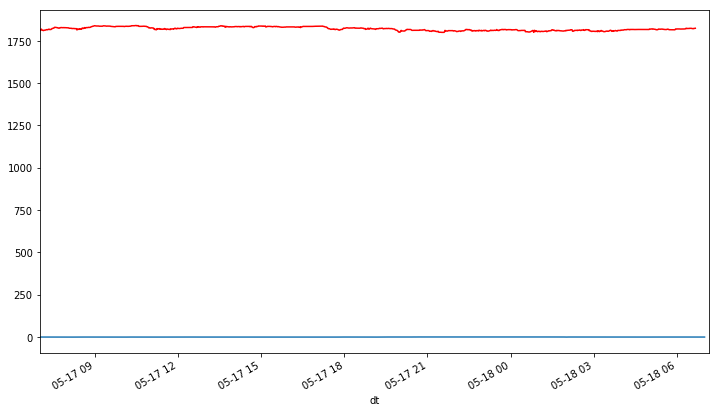

In [240]:
ax=outcomes.sort_index().plot()
query = """
    select dt, close
    from gdax_api_quote
    where dt <= TIMESTAMP '{end_dt}'
        + INTERVAL '10 minutes'
        and dt >= TIMESTAMP '{start_dt}'
        and granularity=60
        and product_id = 'BTC-USD'
""".format(start_dt=start_dt, end_dt=end_dt)
actual = utils.query_pg(query).set_index('dt')['close'].sort_index().shift(-30).plot(ax=ax, color='red')